<a href="https://colab.research.google.com/github/pltnhan/machinelearningplatforms/blob/main/Kernelization_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phạm Lê Thanh Nhàn - ITDSIU20073

# Lab 2a: Kernelization
Support Vector Machines are powerful methods, but they also require careful tuning. We'll explore SVM kernels and hyperparameters on an artificial dataset. We'll especially look at model underfitting and overfitting.

In [ ]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 961.2 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158699 sha256=e898ed0213bd58a12727fc01cff79c5835a0ca7539e38ed410508335bf008401
  Stored in directory: /root/.cache/pip/wheels/2e/4e/af/5e721761d86375dbca82e63cc2470019e97815bc39f11451ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=b9732c646f48b30cd66b48ed2d390a389747d3d991512ca956a8e4e250b306ea
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully bui

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

## Getting the data
We fetch the Banana data from OpenML: https://www.openml.org/d/1460  

In [ ]:
bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');

<ipython-input-4-9c8e7641ea56>:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
<ipython-input-4-9c8e7641ea56>:2: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');


Quick look at the data:

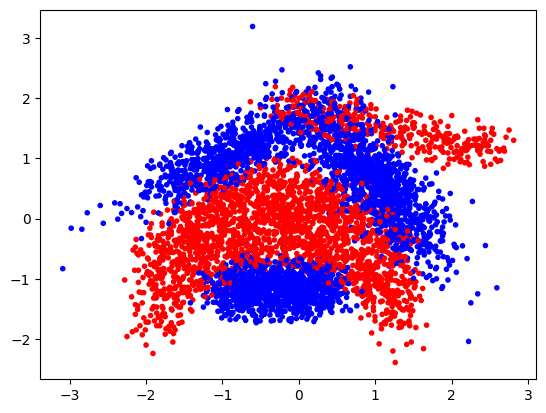

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y,cmap=plt.cm.bwr, marker='.');

In [ ]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn
def plot_svm_kernel(X, y, title, support_vectors, decision_function, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border.
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line

    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    plt.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())

    if show:
        plt.show()

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Exercise 1: Linear SVMs

First, we'll look at linear SVMs and the different outputs they produce. Check the [documentation of LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

The most important inputs are:  
* C -- The C hyperparameter controls the misclassification cost and therefore the amount of regularization. Lower values correspond to more regularization
* loss - The loss function, typically 'hinge' or 'squared_hinge'. Squared hinge is the default. Normal hinge is less strict.
* dual -- Whether to solve the primal optimization problem or the dual (default). The primal is recommended if you have many more data points than features (although our datasets is very small, so it won't matter much).

The most important outputs are:  
* decision_function - The function used to classify any point. In this case on linear SVMs, this corresponds to the learned hyperplane, or $y = \mathbf{wX} + b$. It can be evaluated at every point, if the result is positive the point is classified as the positive class and vice versa.
* coef_ - The model coefficients, i.e. the weights $\mathbf{w}$
* intercept_ - the bias $b$

From the decision function we can find which points are support vectors and which are not: the support vectors are all
the points that fall inside the margin, i.e. have a decision value between -1 and 1, or that are misclassified. Also see the lecture slides.

### Exercise 1.1: Linear SVMs
Train a LinearSVC with C=0.001 and hinge loss. Then, use the plotting function `plot_svm_kernel` to plot the results. For this you need to extract the support vectors from the decision function. There is a hint below should you get stuck.
Interpret the plot as detailed as you can. Afterwards you can also try some different settings. You can also try using the primal instead of the dual optimization problem (in that case, use squared hinge loss).

In [ ]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

clf = LinearSVC(loss='hinge',C=0.001).fit(X, y)

In [ ]:
# Hint: how to compute the support vectors from the decision function (ignore if you want to solve this yourself)
support_vector_indices = np.where((2 * y - 1) * clf.decision_function(X) <= 1)[0]
support_vectors = X[support_vector_indices]

# Note that we can also calculate the decision function manually with the formula y = w*X
# decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]

<ipython-input-5-7c1a2a43cc40>:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


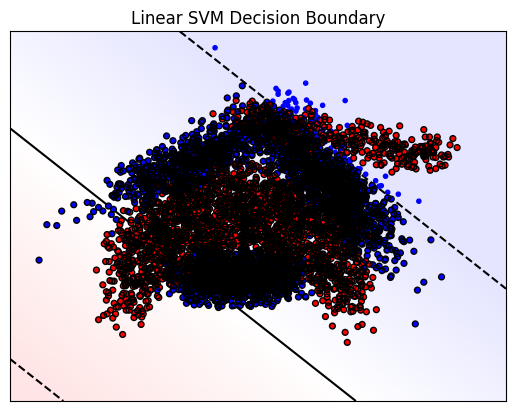

In [ ]:
plot_svm_kernel(X, y, title="Linear SVM Decision Boundary",
                support_vectors=support_vectors,
                decision_function=clf.decision_function, dual_coef=None, show=True)

In [ ]:
from sklearn.model_selection import cross_val_score

score_clf = cross_val_score(clf, X, y, cv=10)  # 5-fold cross-validation
average_accuracy_clf = score_clf.mean()
average_accuracy_clf

0.5677358490566038

<ipython-input-5-7c1a2a43cc40>:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


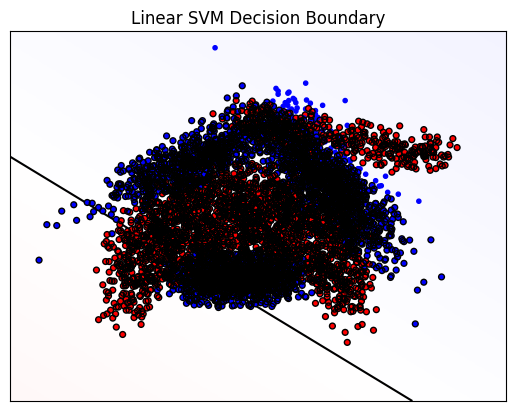

In [ ]:
clf2 = LinearSVC(C=0.001).fit(X,y)

support_vector_indices2 = np.where((2 * y - 1) * clf2.decision_function(X) <= 1)[0]
support_vectors2 = X[support_vector_indices]

plot_svm_kernel(X, y, title="Linear SVM Decision Boundary",
                support_vectors=support_vectors2,
                decision_function=clf2.decision_function, dual_coef=None, show=True)

In [ ]:
score_clf2 = cross_val_score(clf2, X, y, cv=10)
average_accuracy_clf2 = score_clf2.mean()
average_accuracy_clf2

0.5541509433962264

## Exercise 2: Kernelized SVMs

Check the [documentation of SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

It has a few more inputs. The most important:
* kernel - It must be either ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, or your custom defined kernel.
* gamma - The kernel width of the `rbf` (Gaussian) kernel. Smaller values mean wider kernels.
          Only relevant when selecting the rbf kernel.
* degree - The degree of the polynomial kernel. Only relevant when selecting the poly kernel.

There also also more outputs that make our lifes easier:  
* support_vectors_ - The array of support vectors
* n_support_ - The number of support vectors per class
* dual_coef_ - The coefficients of the support vectors (the dual coefficients)

### Exercise 2.1

Evaluate different kernels, with their default hyperparameter settings.
Outputs should be the 5-fold cross validated accuracy scores for the linear kernel (lin_scores), polynomial kernel (poly_scores) and RBF kernel (rbf_scores). Print the mean and variance of the scores and give an initial interpretation of the performance of each kernel.

In [ ]:
from sklearn import svm

# Linear kernel
clf = svm.SVC(kernel='linear')
lin_scores = cross_val_score(clf, X, y, cv=5)

# Polynomial kernel
clf = svm.SVC(kernel='poly')
poly_scores = cross_val_score(clf, X, y, cv=5)

# RBF kernel
clf = svm.SVC(kernel='rbf')
rbf_scores = cross_val_score(clf, X, y, cv=5)

In [ ]:
print("Linear Kernel: {:.2f} +- {:.4f}".format(lin_scores.mean(), np.var(lin_scores)))
print("Polynomial Kernel: {:.2f} +- {:.4f}".format(poly_scores.mean(), np.var(poly_scores)))
print("RBF Kernel: {:.2f} +- {:.5f}".format(rbf_scores.mean(), np.var(rbf_scores)))

Linear Kernel: 0.55 +- 0.0000
Polynomial Kernel: 0.64 +- 0.0000
RBF Kernel: 0.90 +- 0.00005


## Exercise 2: Visualizing the fit
To better understand what the different kernels are doing, let's visualize their predictions.

### Exercise 2.1
Call and fit SVM with linear, polynomial and RBF kernels with default parameter values. For RBF kernel, use kernel coefficient value (gamma) of 2.0. Plot the results for each kernel with "plot_svm_kernel" function. The plots show the predictions made for the different kernels. The background color shows the prediction (blue or red). The full line shows the decision boundary, and the dashed line the margin. The encircled points are the support vectors.

In [ ]:
def plot_svm_kernel(clf):

    fignum = 1
    clf.fit(X, y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(5, 5))
    plt.title('kernel = %s' % (clf.kernel))
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], c=clf.dual_coef_[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)

    x_min, x_max = -3, 3
    y_min, y_max = -3, 3

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(5, 5))
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    #plt.xticks(())
    #plt.yticks(())

    plt.show()

    print('Number of support vectors per class: {}'.format(clf.n_support_))


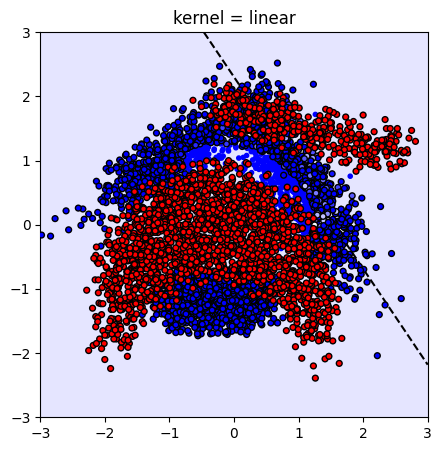

Number of support vectors per class: [2440 2376]


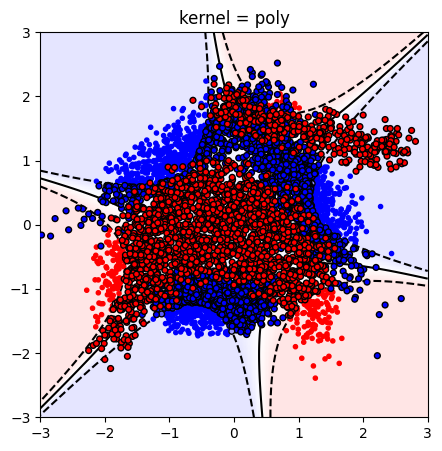

Number of support vectors per class: [2149 2147]


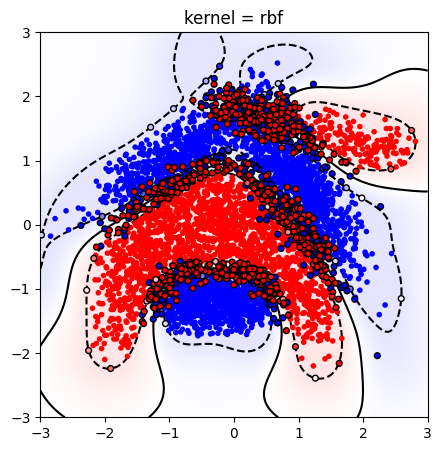

Number of support vectors per class: [642 636]


In [ ]:
plot_svm_kernel(svm.SVC(kernel='linear', C=1.0, tol=1e-3))
plot_svm_kernel(svm.SVC(kernel='poly', C=1.0))
plot_svm_kernel(svm.SVC(kernel='rbf', gamma=2, C=1.0))

### Exercise 2.2
Interpret the plots for each kernel. Think of ways to improve the results.

**Linear**: It's clear that this data is not linearly separable. The linear SVM is badly underfitting. There also appear to be some optimization issues, as the decision boundary lies way outside of the image, and there is a group of non-support vectors that should be support vectors. Forcing more optimization (by decreasing tolerance `tol`) yields slightly better results. See below.

**Polynomial**: A slightly better fit, but clearly polynomials aren't the best fit either. They divide the space in subspaces that don't capture the banana shapes at all.

**RBF**: Works very nicely, and the default settings seem to actually hit the sweet spot. We should still try to tune C and gamma.

In [ ]:
plot_svm_kernel(svm.SVC(kernel='linear', C=1.0, tol=1e-15))

## Exercise 3: Visualizing the RBF models and hyperparameter space
Select the RBF kernel and optimize the two most important hyperparameters (the 𝐶 parameter and the kernel width 𝛾 ).

Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale.

In [ ]:
def plot_svm_kernels(kernel,gamma,C):
    scores = []
    # fit the model
    clf = svm.SVC(kernel='rbf',C=float(C),gamma=float(gamma))
    clf.fit(X, y)
    scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc');
    # plot the line, the points, and the nearest vectors to the plane
    plt.title('C=%s gamma=%s\ns.v.=%d auc=%.3f' % (
            C, gamma, clf.support_vectors_.shape[0], scores.mean()
        ));
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=70, edgecolors='k', c=clf.dual_coef_[0, :], zorder=10, marker = '.')
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker = '.')
    plt.axis('tight')

    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())

### Exercise 3.1
First try 3 very different values for $C$ and $\gamma$ (for instance [1e-3,1,1e3]). For each of the 9 combinations, create the same RBF plot as before to understand what the model is doing. Also create a standard train-test split and report the train and test score. Explain the performance results. When are you over/underfitting? Can you see this in the predictions?

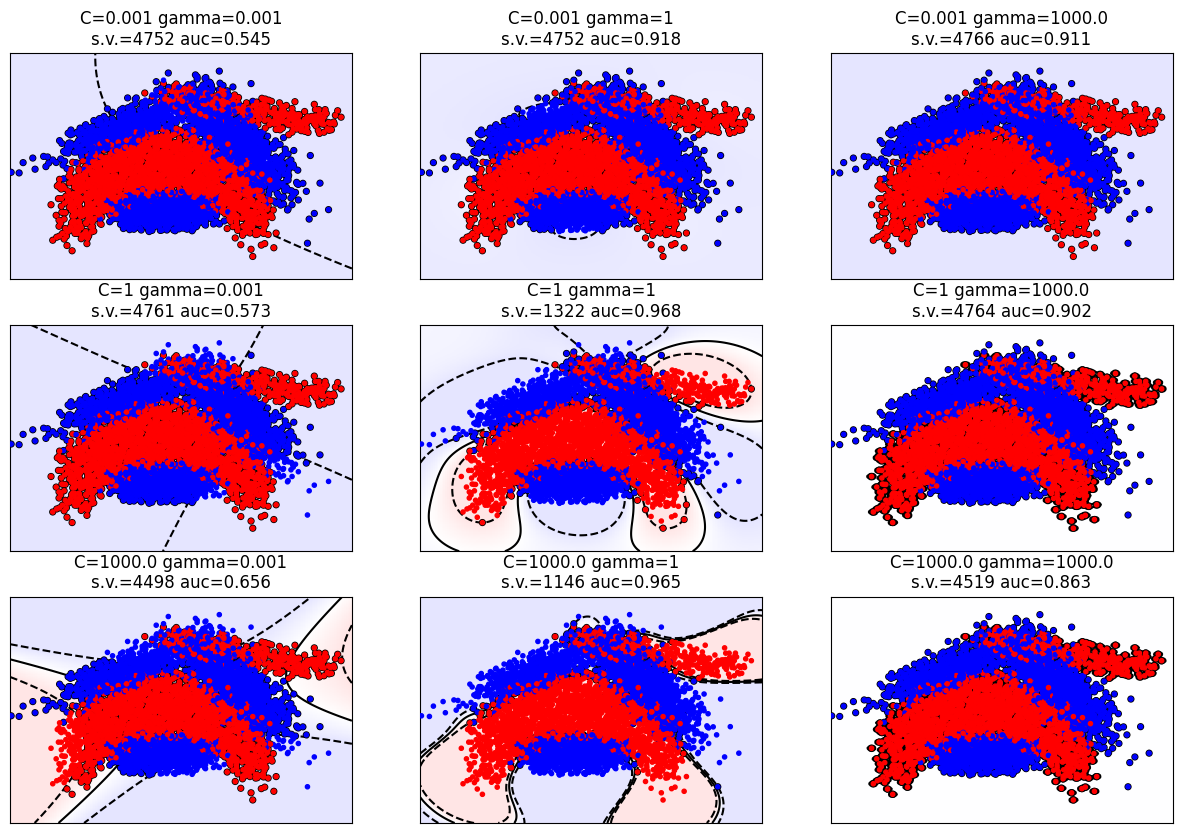

In [ ]:
plt.figure(figsize=(15, 10))
fig_num = 0
for c in [1e-3, 1, 1e3]:
    for gamma in [1e-3, 1, 1e3]:
        fig_num += 1
        plt.subplot(3, 3, fig_num)
        plot_svm_kernels('rbf',gamma,c)
plt.show();

- For gamma = 1e3 (1000) (narrow Gaussians), almost all datapoints are support vectors, and the decision boundaries are islands around each point. Those are clearly overfitting.
- When gamma very low (wide Gaussians), it always seems to be underfitting.
- Best results are for medium C, medium gamma (also fewest support vectores). The decision boundaries show that it captures the banana shapes well.
- C has relatively little influence on performance, although large C values tend to cause more overfitting. For gamma=1, you can also see that the margins for C=1e3 (1000) are much more narrow than those for C=1.

### Exercise 3.2
Optimize the hyperparameters using a grid search, trying every possible combination of C and gamma. Show a heatmap of the results and report the optimal hyperparameter values. Use at least 10 values for $C$ and $\gamma$ in [$2^{-15}..2^{15}$] on a log scale. Report accuracy under 3-fold CV. We recommend to use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and the `heatmap` function defined above. Check their documentation.

In [ ]:
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(kernel='rbf')
param_grid = {'C': np.logspace(-15,15,25,base=2),
              'gamma': np.logspace(-15,15,25,base=2)}
grid_search = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, scoring='roc_auc');
grid_search.fit(X, y);

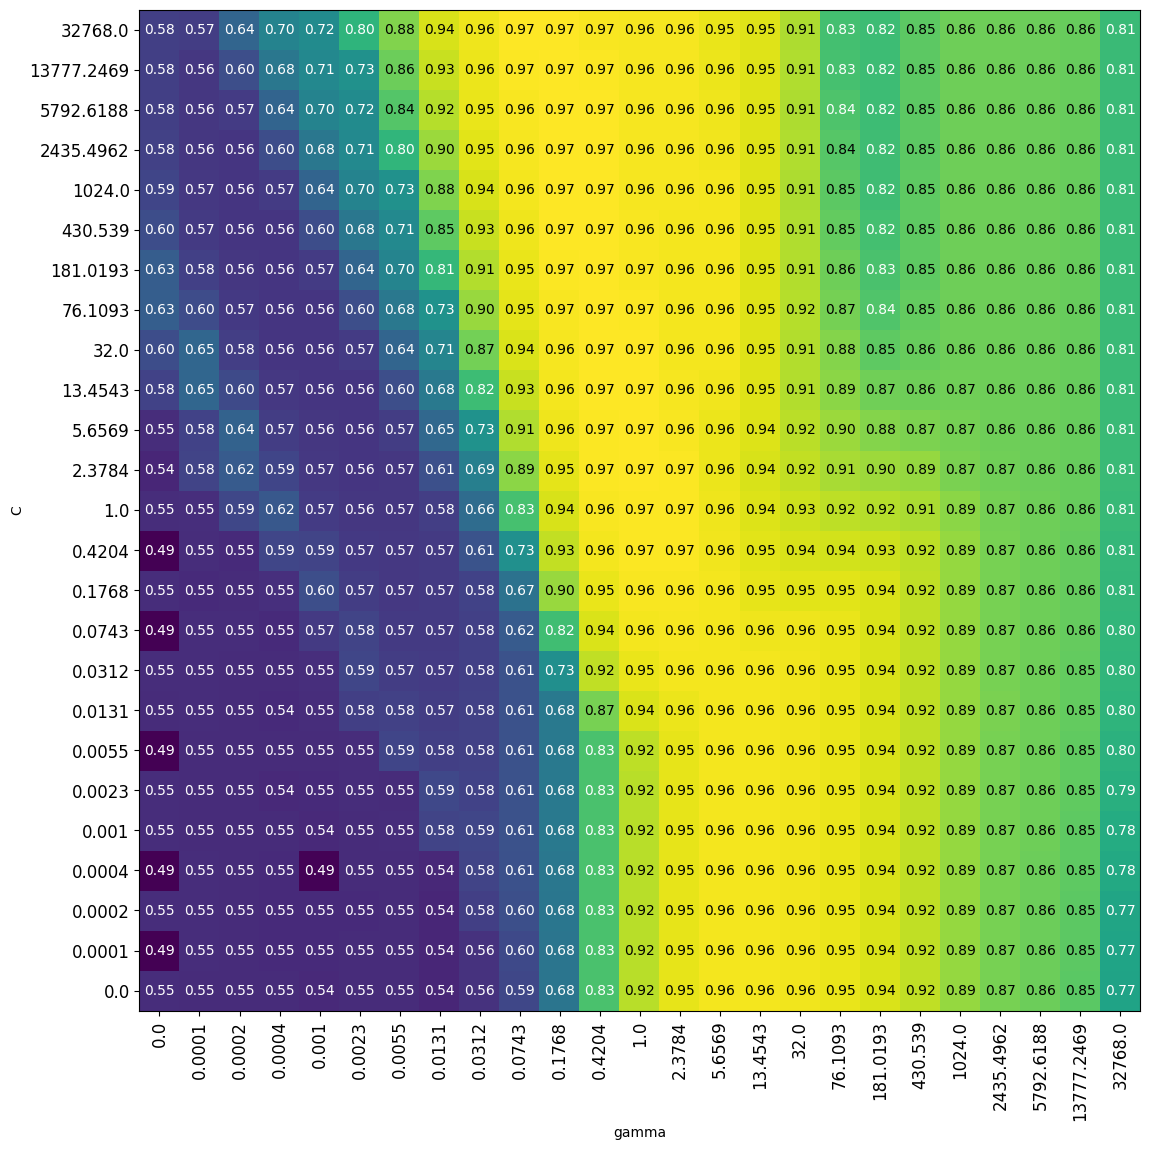

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(25, 25)
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1, 1, figsize=(13, 13))
heatmap(scores, xlabel='gamma', xticklabels=np.around(param_grid['gamma'],4),
                      ylabel='C', yticklabels=np.around(param_grid['C'],4), cmap="viridis", fmt="%.2f", ax=axes);